# Classification task

In [118]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)
np.set_printoptions(precision=2)

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder, cat_boost

from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import optuna

import torch
from torch import nn, optim

cv_scoring=['roc_auc', 'recall']
target_metrics = [metrics.roc_auc_score, metrics.recall_score]
objective_names = ['ROC AUC', 'recall']
fromkeys = lambda d, keys: {x:d.get(x) for x in keys}

## Helpful functions

In [2]:
def type_casting(df_in):
    df = df_in.copy()
    cat_features = ['store_id','region_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

In [3]:
def boxplots_top_stores(df, columns, num_stores=5):
    top_stores = df.value_counts('store_id').sort_values(ascending=False)[:num_stores].index

    _, axes = plt.subplots(nrows=len(columns), 
                        ncols=num_stores+2, figsize=(num_stores*5, len(columns) * 3))
    for idx, feature in enumerate(columns):
        sns.histplot(df[feature], 
                    stat='density', 
                    kde=True,
                    bins=35, ax=axes[idx, 0])
        sns.boxplot(x=feature, data=df, ax=axes[idx, 1]).set_xlabel(feature + ' for all stores')
        for shifted_idx, store_id in enumerate(top_stores, 2):
            sns.boxplot(x=feature, 
                        data=df[df['store_id']==store_id], 
                        ax=axes[idx, shifted_idx]).set_xlabel(feature + ' for ' + str(store_id))
    plt.tight_layout()

In [4]:
def sort_dates(df_in, date_columns):
    df = df_in.copy()
    mask_any_na_dates = df[date_columns].isna().any(axis=1)
    df.loc[~mask_any_na_dates, date_columns] = np.sort(df.loc[~mask_any_na_dates, date_columns].values, axis=1)
    return df

In [5]:
def rm_outliers(df_in, features, quantiles: np.array, verbose=1):
    assert len(features) == len(quantiles)
    df = df_in.copy()
    if verbose:
        print('Shape before removing outliers: ', df.shape)
    IQR = stats.iqr(df[features], axis=0, nan_policy='omit')
    
    mask_non_outliers = df.groupby("store_id")[features]\
        .apply(lambda x : (x>=(np.diag(x.quantile(quantiles[:,0])) - 1.5 * IQR)) 
                        & (x<=(np.diag(x.quantile(quantiles[:,1])) + 1.5 * IQR))\
              ).all(axis=1).values
    df = df[mask_non_outliers]
    if verbose:
        print('Shape after removing outliers: ', df.shape)
    return df

In [6]:
def calc_statistic(frame, method):
    match method:
        case 'mode':
            return frame.mode()
        case 'mean':
            return frame.mean()
        case 'median':
            return frame.median()
        case _:
            raise NameError("Method is not exist") 

In [7]:
def impute_dates_by_store(x_in, method):
    x = x_in.copy()
    # calculate statistics value for recover null observation in regarding the neighbour date feature
    diff_date = x['order_pickup'] - x['order_ready']
    diff_timestamp_statistic = calc_statistic(diff_date[diff_date > pd.to_timedelta("0 days")], method)    

    # From EDA, this column hasn't null rows, but to be sure this code will be left 
    # order_pickup = order_ready + method(order_pickup - order_ready)
    mask_null_order_pickup = x['order_pickup'].isnull() 
    x.loc[mask_null_order_pickup, 'order_pickup'] = \
        x.loc[mask_null_order_pickup, 'order_ready'] + diff_timestamp_statistic
    
    # order_ready = order_pickup - method(order_pickup - order_ready)
    mask_null_order_ready = x['order_ready'].isnull()
    x.loc[mask_null_order_ready, 'order_ready'] = \
        x.loc[mask_null_order_ready, 'order_pickup'] - diff_timestamp_statistic

    # New feature that relfects waiting time for the order to be accepted for processing
    x['order_delay'] = x['order_start_prepare'] - x['date_create']
    diff_timestamp_statistic = calc_statistic(x['order_delay'][x['order_delay'] > pd.to_timedelta("0 days")], method)    
    x['order_delay'] = x['order_delay'].dt.total_seconds() / 60

    # order_start_prepare = date_create + method(order_start_prepare - date_create)
    mask_null_order_start_prepare = x['order_start_prepare'].isnull()
    x.loc[mask_null_order_start_prepare, 'order_start_prepare'] = \
        x.loc[mask_null_order_start_prepare, 'date_create'] + diff_timestamp_statistic
    
    # date_create = order_start_prepare - method(order_start_prepare - date_create)
    mask_null_date_create = x['date_create'].isnull()
    x.loc[mask_null_date_create, 'date_create'] = \
        x.loc[mask_null_date_create, 'order_start_prepare'] - diff_timestamp_statistic

    return x

In [8]:
def impute_dates(df_in, method='mode'):
    df = df_in.copy()
    # Restore dates within a certain store_id by method of differences neighboor columns 
    # (order_pickup - order_ready) & (order_start_prepare - date_create)
    df.loc[:,['date_create','order_start_prepare','order_ready','order_pickup','order_delay']] = df.groupby("store_id")\
            .apply(lambda x: impute_dates_by_store(x, method))\
            .reset_index(allow_duplicates=True)\
            .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup','order_delay']]
    return df

In [9]:
def extract_target(df_in, q_target=0.75, test_subset=False, verbose=1):
    df = df_in.copy()
    df['actual_prep_time'] = (df['order_ready'] - df['order_start_prepare']).dt.total_seconds() / 60
    
    mask_null_prep_time = df['actual_prep_time'].isnull() 
    if not test_subset:
        df['diff_time'] = df['actual_prep_time'] - df['planned_prep_time']
        
        mask_neg_prep_time = df['actual_prep_time'] < 0
        IQR = stats.iqr(df['diff_time'], nan_policy='omit')
        mask_outliers_in_diff_time = df['diff_time'] > (df['diff_time'].quantile(q_target) + 1.5 * IQR)

        if verbose:
            print("Nan's in actual_prep_time: ", mask_null_prep_time.sum(),
                "\nNegatives: ", mask_neg_prep_time.sum(),
                '\nOutliers in time difference: ', mask_outliers_in_diff_time.sum())
        
        df.drop(columns='diff_time', inplace=True)
        df.dropna(subset=['date_create','planned_prep_time'], inplace=True)
        mask_anomaly = mask_neg_prep_time | mask_null_prep_time | mask_outliers_in_diff_time
    else:
        mask_anomaly = mask_null_prep_time
    
    if verbose:
        print("All anomalyes: ", df.loc[mask_anomaly].shape[0])
    df = df.loc[~mask_anomaly]
    df['on_time'] = np.where(abs(df['planned_prep_time'] - df['actual_prep_time']) <= 5, 1, 0)
    return df.drop(columns=['order_ready','order_pickup','actual_prep_time', 'on_time']), df['on_time']


In [10]:
def encode_cyclical_feat(df_in: pd.DataFrame, col: pd.Series, col_name: str):
    df = df_in.copy()
    df[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    df[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return df

In [11]:
def extract_date_feat(df_in: pd.DataFrame, data_features: list, drop=True, encode_cyclical=True):
    df = df_in.copy()
    if encode_cyclical:
        for col_name in data_features:
            df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
            df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
            df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
            df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
            df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    else:
        for col_name in data_features:
            df[col_name + '_month'] = df[col_name].dt.month
            df[col_name + '_day'] = df[col_name].dt.day
            df[col_name + '_weekday'] = df[col_name].dt.weekday
            df[col_name + '_hour'] = df[col_name].dt.hour
            df[col_name + '_minute'] = df[col_name].dt.minute
            
    if drop:
        df = df.drop(columns=data_features)
    return df

In [12]:
def simple_imputer(X_train, X_test, y_train, y_test, restore_numerical_nans=True, 
                   imputing_method_for_numerical='mode', 
                   imputing_method_for_simple_imputer='most_frequent', verbose=1):
    na_columns_train = X_train.columns[X_train.isna().any()]
    na_columns_test = X_test.columns[X_test.isna().any()]

    if verbose: 
        print("Numbers of NaN values\n\tTrain:\n", X_train[na_columns_train].isna().sum())
        print("\n\tTest:\n", X_test[na_columns_test].isna().sum())

    if restore_numerical_nans:
        X_train.loc[:,na_columns_train] = X_train.groupby("store_id")\
            [na_columns_train].transform(lambda x: x.fillna(calc_statistic(x, imputing_method_for_numerical)))
        X_test.loc[:,na_columns_test] = X_test.groupby("store_id")\
            [na_columns_test].transform(lambda x: x.fillna(calc_statistic(x, imputing_method_for_numerical)))

        ####################################### Imputting #####################################
        col_imputing = X_test.columns[X_test.isna().any()].union(X_train.columns[X_train.isna().any()])
        if verbose:
            print("Remaining numbers of NaN values\n\tTrain:\n", X_train[col_imputing].isna().sum())
            print("\n\tTest:\n", X_test[col_imputing].isna().sum())

        imputer = SimpleImputer(strategy=imputing_method_for_simple_imputer)
        X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), 
                                            columns=col_imputing, index=X_train.index)
        X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), 
                                            columns=col_imputing, index=X_test.index)
    else:
        index_train_na, index_test_na = X_train[na_columns_train].isnull().any(axis=1), \
                                        X_test[na_columns_test].isnull().any(axis=1)    
        X_train, y_train, X_test, y_test = X_train[~index_train_na], y_train[~index_train_na], \
                                        X_test[~index_test_na], y_test[~index_test_na]
    return X_train, X_test, y_train, y_test

In [13]:
def scores(estimator, X_test, y_test, X_train, y_train, cv=5, cv_scoring=cv_scoring, threshold=0.5, plot=True, ax=None):
    precision = 3
    if threshold:
        pred_proba = estimator.predict_proba(X_test)
        y_test_pred = np.where(pred_proba[:, 1] > threshold, 1, 0)
    else:
        y_test_pred = estimator.predict(X_test)

    # calculate metrics
    print(f'- Testing accuracy = {metrics.accuracy_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing precision = {metrics.precision_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing recall = {metrics.recall_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing f1_score = {metrics.f1_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing ROC AUC = {metrics.roc_auc_score(y_test, y_test_pred):.{precision}f}')
    if cv:
        print('- Cross validate: ', model_selection.cross_validate(estimator, 
                                                                  pd.concat([X_train, X_test]), 
                                                                  pd.concat([y_train, y_test]), 
                                                                  cv=cv, scoring=cv_scoring))
  
    if plot: 
        cm = confusion_matrix(y_test, y_test_pred, labels=estimator.classes_, 
                        #   normalize='true'
                        )
        ConfusionMatrixDisplay(cm, display_labels=estimator.classes_).plot(ax=ax)
        return cm
    

## EDA

In [14]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

In [43]:
X, y = extract_target(orders, 1.0)
date_columns = ['date_create', 'order_start_prepare']
df = pd.concat([X,y], axis=1)
df.shape

Nan's in actual_prep_time:  97930 
Negatives:  1855 
Outliers in time difference:  0
All anomalyes:  99716


(417620, 15)

([<matplotlib.patches.Wedge at 0x7f9d282a9030>,
 [Text(-0.14313714705728628, 1.0906474027532, 'Late'),
  Text(0.14313714705728586, -1.0906474027532, 'On time')],
 [Text(-0.0780748074857925, 0.5948985833199272, '54.2%'),
  Text(0.07807480748579228, -0.5948985833199273, '45.8%')])

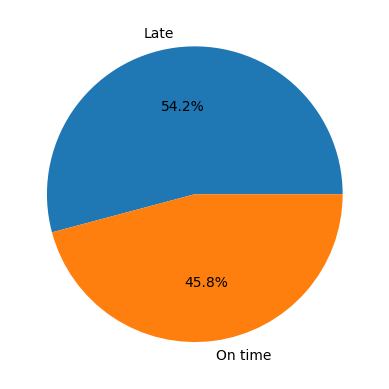

In [44]:
plt.pie(x=y.value_counts().values,
        labels=y.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

In [45]:
top_stores = df['store_id'].value_counts().index[:12]
print('Top stores: ', top_stores)
df_top_stores = df[df['store_id'].isin(top_stores)]
df_top_stores.shape

Top stores:  Index([3503, 5212, 5014, 4742, 3902, 3141, 4755, 3053, 6579, 3496, 3766,
       10489],
      dtype='object', name='store_id')


(52308, 15)

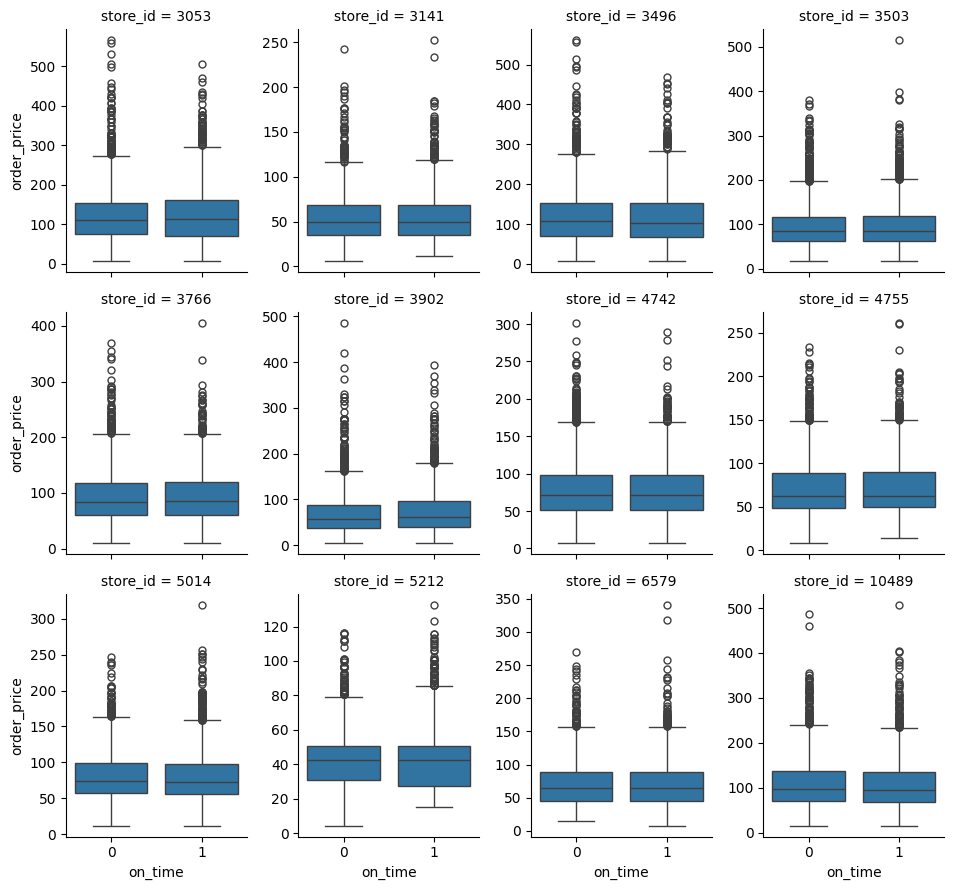

In [46]:
sns.catplot(
    x="on_time",
    y="order_price",
    col="store_id",
    data=df_top_stores,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8, sharey=False
)

In [47]:
df_extracted_dates = extract_date_feat(df_top_stores, date_columns, encode_cyclical=False)
df_extracted_dates.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'status_id', 'products_count', 'order_price', 'max_price',
       'min_price', 'avg_price', 'unique_products_sold_by_store', 'on_time',
       'date_create_month', 'date_create_day', 'date_create_weekday',
       'date_create_hour', 'date_create_minute', 'order_start_prepare_month',
       'order_start_prepare_day', 'order_start_prepare_weekday',
       'order_start_prepare_hour', 'order_start_prepare_minute'],
      dtype='object')

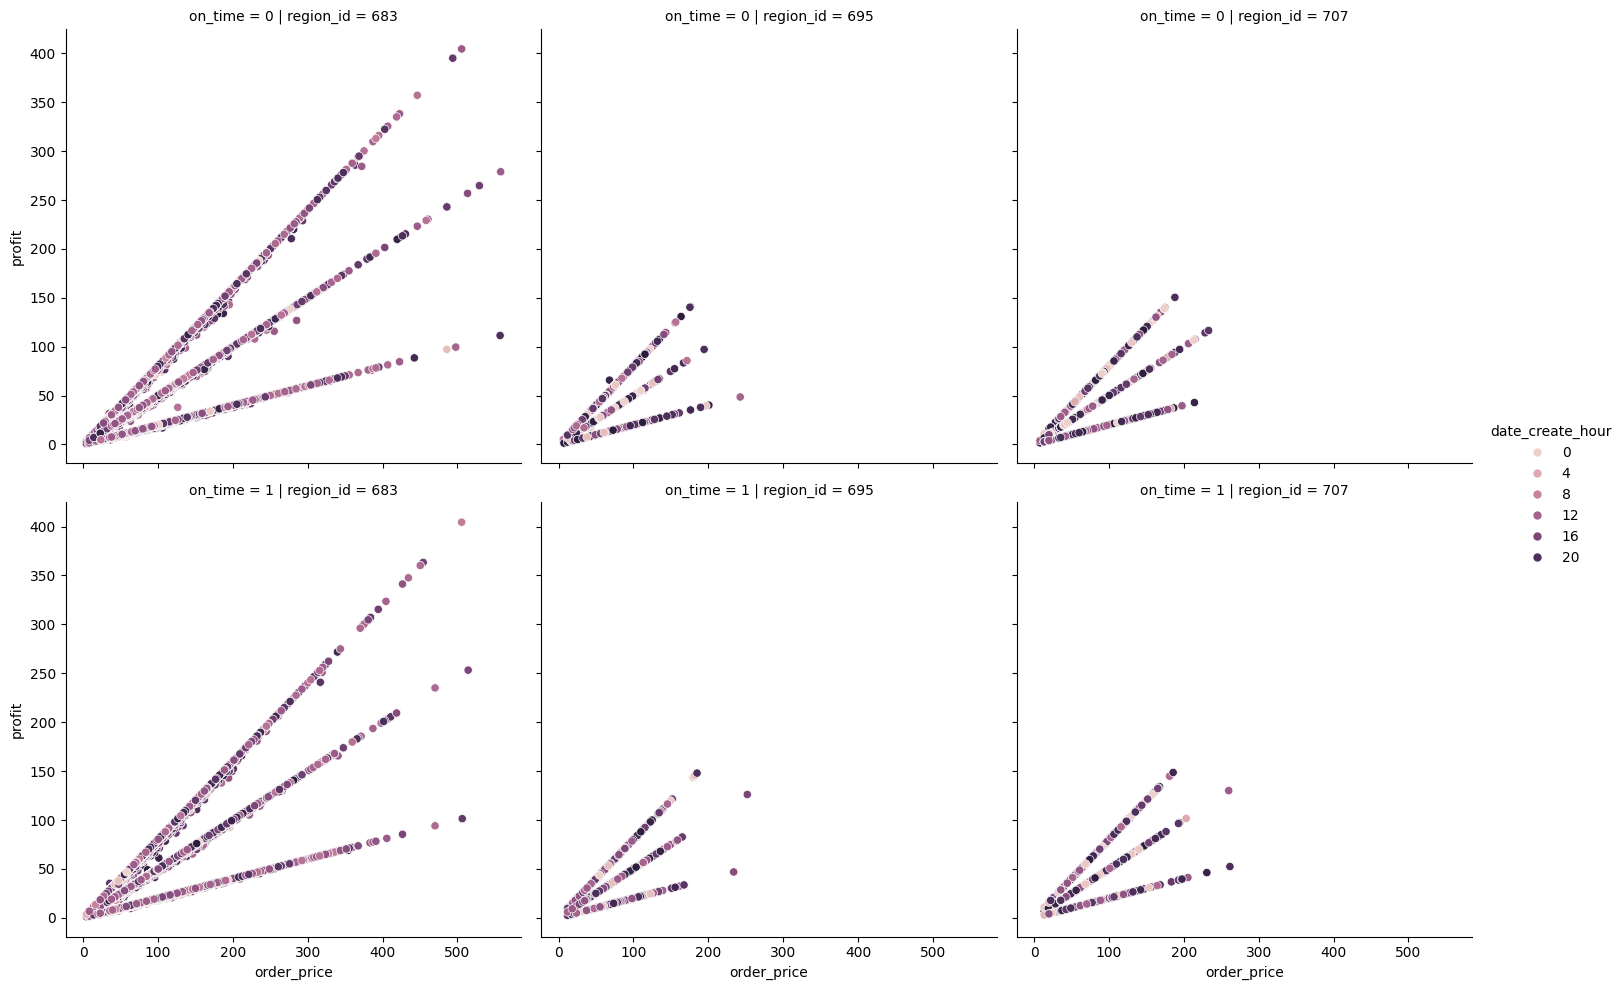

In [48]:
sns.relplot(df_extracted_dates, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='date_create_hour', #hue_order=(15, 90),
            col="region_id", row='on_time')

The same, but without outliers

Shape before removing outliers:  (417620, 23)
Shape after removing outliers:  (368308, 23)


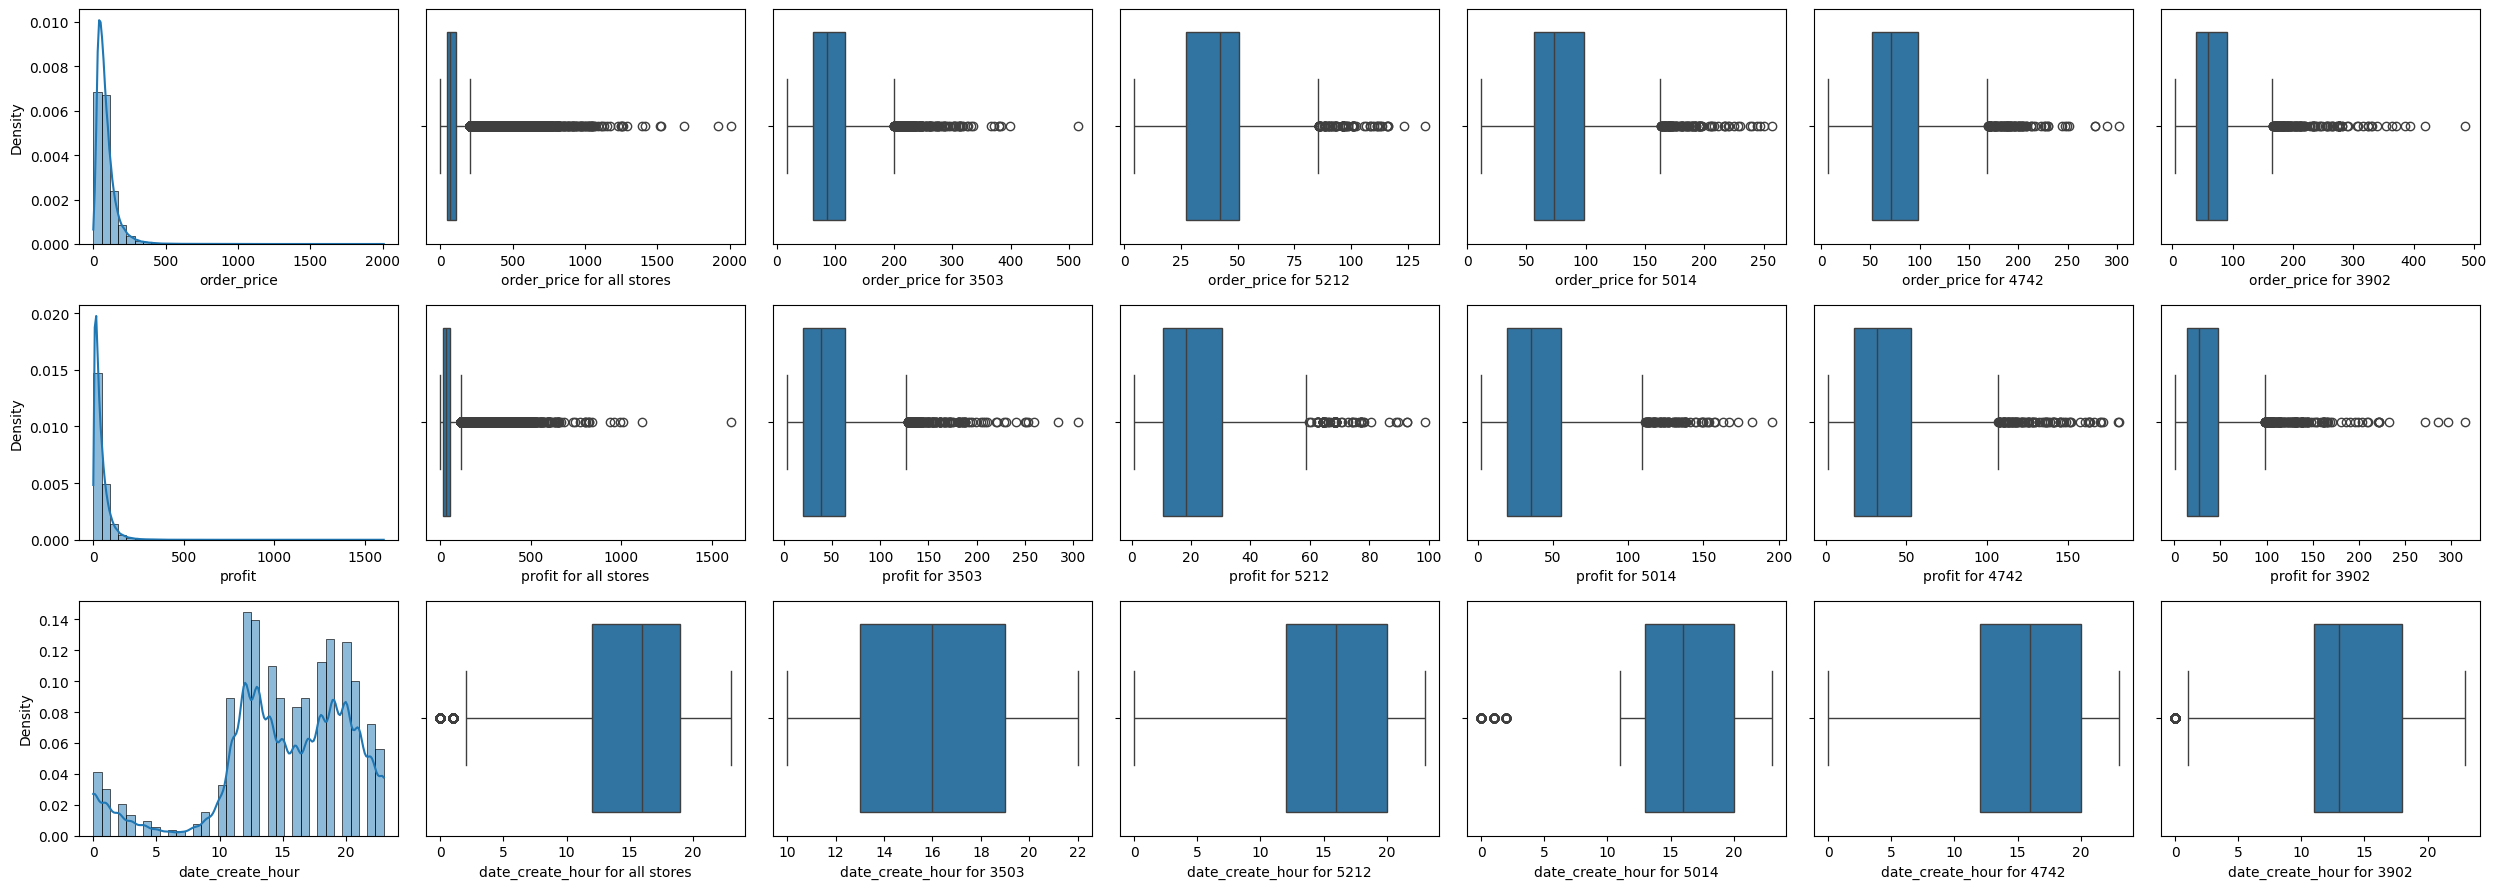

In [49]:
df_without_outliers = rm_outliers(extract_date_feat(df, date_columns, encode_cyclical=False), 
                                  ['order_price', 'profit'], np.array([[0.0, 0.9]]*2))
boxplots_top_stores(df_without_outliers, ['order_price', 'profit', 'date_create_hour'])

In [50]:
top_stores = df_without_outliers['store_id'].value_counts().index[:12]
print('Top stores: ', top_stores)
df_top_stores = df_without_outliers[df_without_outliers['store_id'].isin(top_stores)]
df_top_stores.shape

Top stores:  Index([3503, 5212, 5014, 4742, 3902, 3141, 4755, 3053, 6579, 3496, 3766,
       10489],
      dtype='object', name='store_id')


(46122, 23)

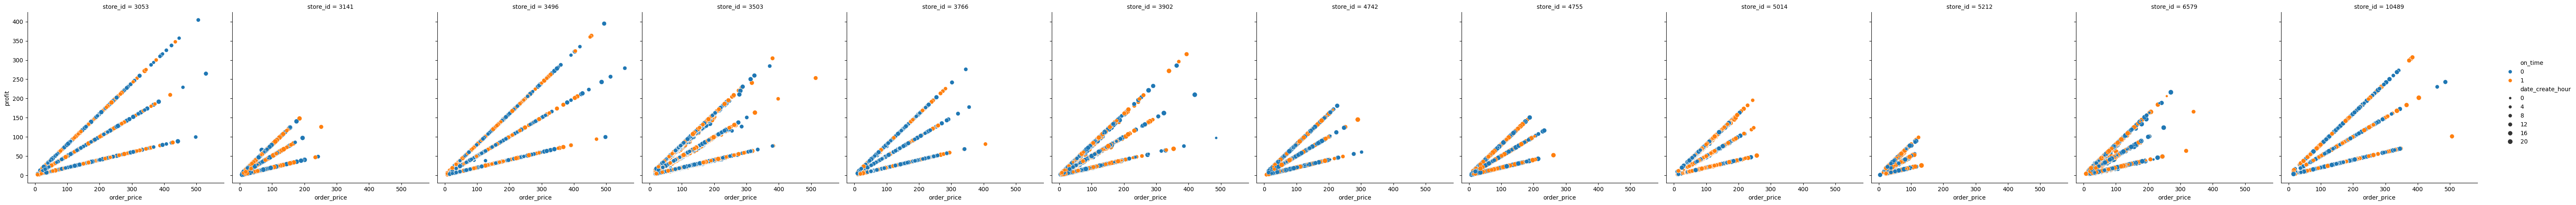

In [51]:
sns.relplot(df_top_stores, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='on_time', #hue_order=(15, 90),
            size='date_create_hour',
            col="store_id", 
            # row='region_id'
            )

In [65]:
number_columns = df.select_dtypes('number').columns
number_columns

Index(['profit', 'delivery_distance', 'planned_prep_time', 'products_count',
       'order_price', 'max_price', 'min_price', 'avg_price',
       'unique_products_sold_by_store', 'on_time'],
      dtype='object')

In [87]:
df.groupby('status_id')[number_columns].describe()['planned_prep_time']

,count,mean,std,min,25%,50%,75%,max
status_id,,,,,,,,
C,58.00000,23.48276,13.18591,5.00000,15.00000,20.00000,30.00000,85.00000
F,417562.00000,23.28454,8.26111,0.00000,20.00000,20.00000,30.00000,180.00000


## Models

### Logistic Regression

#### Preprocessing

In [15]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

In [16]:
orders = sort_dates(orders, date_columns)

In [17]:
features_for_rm_outls = orders.select_dtypes('number').columns
# boxplots_top_stores(orders, features_for_rm_outls)

In [18]:
quantiles = np.array([[0.25, 0.75]]*len(features_for_rm_outls))
rmvd_outliers = rm_outliers(orders, features_for_rm_outls, quantiles)
# boxplots_top_stores(rmvd_outliers, features_for_rm_outls)

Shape before removing outliers:  (517610, 16)


Shape after removing outliers:  (412084, 16)


In [19]:
rmvd_outliers['status_id'].value_counts(dropna=False)

status_id
F    412008
C        76
Name: count, dtype: int64

<Axes: >

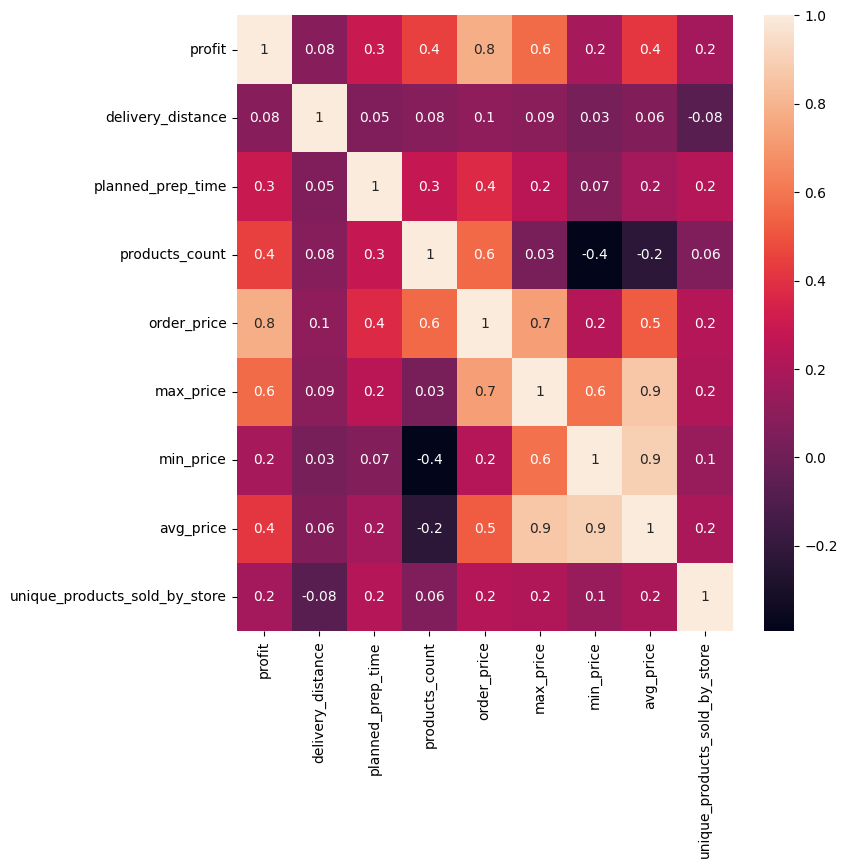

In [20]:
plt.subplots(figsize=(8,8))
corr_matrix = rmvd_outliers.select_dtypes('number').corr()
sns.heatmap(corr_matrix, annot=True, fmt='.1g')

In [21]:
rmvd_outliers = rmvd_outliers.drop(columns=['status_id','avg_price'])

In [22]:
X_train, X_test = train_test_split(rmvd_outliers, train_size=0.9, shuffle=True)

In [23]:
X_train = impute_dates(X_train, 'mean')
X_test = impute_dates(X_test, 'mean')

In [24]:
X_train, y_train = extract_target(X_train, q_target=0.75)
X_test, y_test = extract_target(X_test, test_subset=True)
data_features = ['date_create','order_start_prepare']

Nan's in actual_prep_time:  29 
Negatives:  473 
Outliers in time difference:  12580
All anomalyes:  13061
All anomalyes:  23


<Axes: >

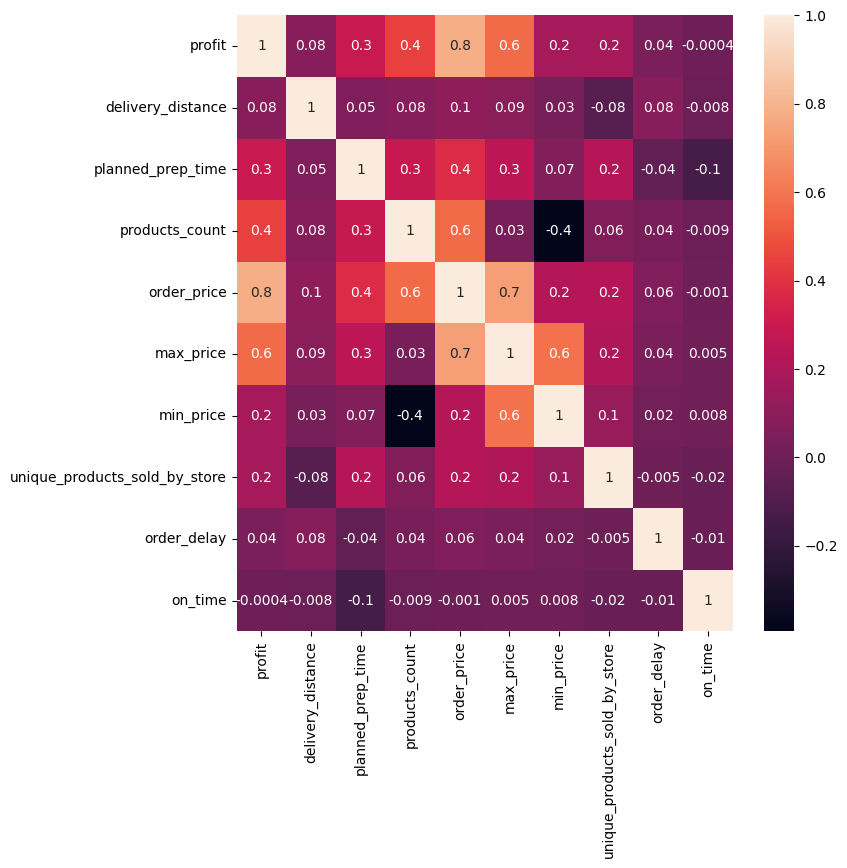

In [25]:
plt.subplots(figsize=(8,8))
corr_matrix = pd.concat([X_train.select_dtypes('number'), y_train], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.1g')

There is some correlation with planned_prep_time

([<matplotlib.patches.Wedge at 0x7efb967baa40>,
 [Text(-0.11900142493341523, 1.0935440827254368, 'Late'),
  Text(0.11900142493341485, -1.0935440827254368, 'On time')],
 [Text(-0.0649098681454992, 0.596478590577511, '53.5%'),
  Text(0.064909868145499, -0.596478590577511, '46.5%')])

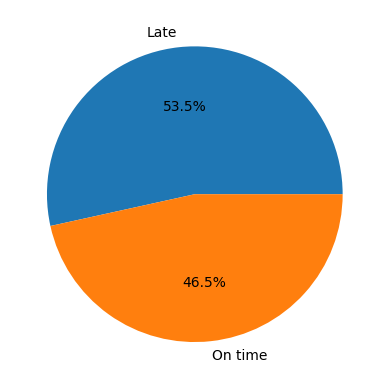

In [26]:
plt.pie(x=y_train.value_counts().values,
        labels=y_train.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

The classes are almost balanced

In [27]:
X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)
X_train.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'products_count', 'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store', 'order_delay', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos'],
      dtype='object')

In [28]:
X_train, X_test, y_train, y_test = simple_imputer(X_train, X_test, y_train, y_test, 
                                                  imputing_method_for_numerical='mean', imputing_method_for_simple_imputer='mean')

Numbers of NaN values
	Train:
 profit         35609
max_price        139
min_price        139
order_delay    35009
dtype: int64

	Test:
 profit         3948
max_price        15
min_price        15
order_delay    4144
dtype: int64
Remaining numbers of NaN values
	Train:
 max_price    0
min_price    0
profit       3
dtype: int64

	Test:
 max_price     1
min_price     1
profit       12
dtype: int64


In [29]:
###################################### Encoding #####################################
cat_features = ['store_id','region_id']
encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [30]:
##################################### Scaling #####################################
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out(), index=X_test.index)

In [31]:
X_train.shape, X_test.shape

((357792, 31), (41186, 31))

#### Training

In [32]:
def get_best_threshold(model, X_test, y_test, objective_targets, objectives_names=None, plot=False):
    thresholds = np.arange(0.1, 0.9, 0.01)
    pred_proba = model.predict_proba(X_test)

    averaged_results = []
    results = [[] for i in range(len(objective_targets)) ]
    for i in thresholds:
        y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
        [
            results[idx].append(metric_func(y_test, y_test_pred_thr)) 
            for idx, metric_func 
            in enumerate(objective_targets)
        ]
        averaged_results.append(np.min([result[-1] for result in results]))
    
    if plot:
        [plt.plot(thresholds, results[idx], label=objectives_names[idx]) 
        for idx, metric in enumerate(objective_targets)]
        plt.title('Threshold Selection')
        plt.xlabel('threshold')
        plt.ylabel('score')
        plt.legend()
        plt.grid()

    return np.max(averaged_results), thresholds[np.argmax(averaged_results)]

In [33]:
def logistic_regressor(X_train, y_train, X_test, y_test, objective_targets=target_metrics, objectives_names=None, plot=False):
    clf = LogisticRegression(random_state=42, n_jobs=-1).fit(X_train, y_train)
    return clf, get_best_threshold(clf, X_test, y_test, objective_targets, objectives_names, plot)

In [34]:
def logistic_regressor_scores(clf, X_test, y_test, X_train, y_train, cv=5, cv_scoring=cv_scoring, best_threshold=0.5, plot=False):
    print("----Logistic Regression Coefficients----")
    importance_features = {col: abs(w)  for col, w in zip(list(X_train.columns), clf.coef_[0])}
    importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse=True))

    _, axes = plt.subplots(1,2, figsize=(12,5))
    sns.barplot(importance_features, 
                orient='h',
                ax=axes[0]).set_title('Feature weight in Logistic regression')

    scores(clf, X_test, y_test, X_train, y_train, cv, cv_scoring, threshold=best_threshold, ax=axes[1], plot=plot)
    plt.tight_layout()
    plt.show()

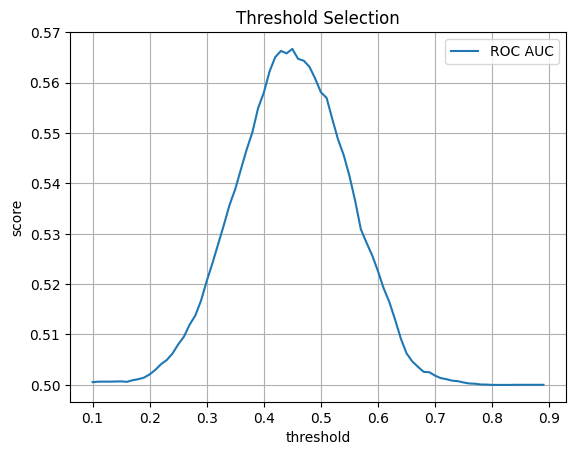

In [35]:
clf, min_of_all_scores__best_threshold = logistic_regressor(X_train, y_train, X_test, y_test, 
                                                            objective_targets=target_metrics, objectives_names=objective_names, 
                                                            plot=True)
min_of_all_scores, best_threshold = min_of_all_scores__best_threshold

----Logistic Regression Coefficients----
- Testing accuracy = 0.566 
- Testing precision = 0.517 
- Testing recall = 0.572 
- Testing f1_score = 0.543 
- Testing ROC AUC = 0.567


- Cross validate:  {'fit_time': array([4.05, 3.69, 3.71, 3.88, 3.68]), 'score_time': array([0.06, 0.05, 0.05, 0.05, 0.04]), 'test_roc_auc': array([0.6 , 0.61, 0.61, 0.61, 0.6 ])}


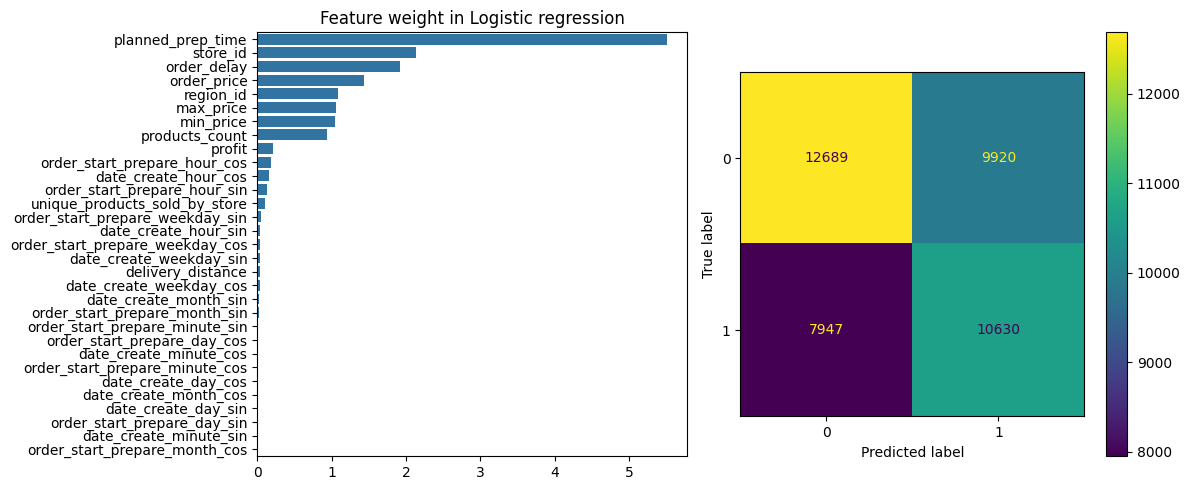

In [36]:
logistic_regressor_scores(clf, X_test, y_test, X_train, y_train, cv=5, cv_scoring=cv_scoring, best_threshold=best_threshold, plot=True)

#### Balancing dataset

([<matplotlib.patches.Wedge at 0x7efb95a96d10>,
 [Text(-0.11900142493341523, 1.0935440827254368, 'Late'),
  Text(0.11900142493341485, -1.0935440827254368, 'On time')],
 [Text(-0.0649098681454992, 0.596478590577511, '53.5%'),
  Text(0.064909868145499, -0.596478590577511, '46.5%')])

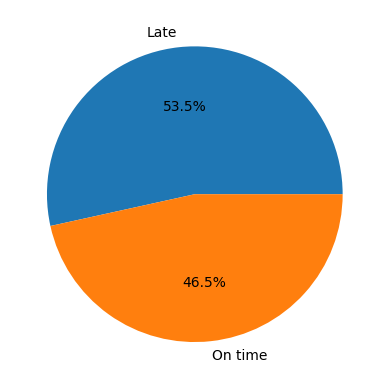

In [37]:
plt.pie(x=y_train.value_counts().values,
        labels=y_train.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

In [38]:
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=500).fit_resample(X_train, y_train)

print(X_train.shape, y_train.value_counts())
print(X_smote.shape, y_smote.value_counts())

(357792, 31) on_time
0    191241
1    166551
Name: count, dtype: int64
(382482, 31) on_time
0    191241
1    191241
Name: count, dtype: int64


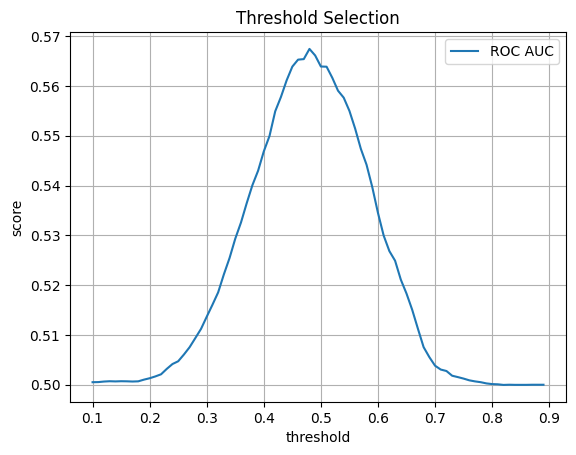

In [39]:
clf_smote, min_of_all_scores__best_threshold = logistic_regressor(X_smote, y_smote, X_test, y_test, 
                                                                  objective_targets=target_metrics, objectives_names=objective_names, 
                                                                  plot=True)
min_of_all_scores, best_threshold_smote = min_of_all_scores__best_threshold

----Logistic Regression Coefficients----
- Testing accuracy = 0.566 
- Testing precision = 0.517 
- Testing recall = 0.583 
- Testing f1_score = 0.548 
- Testing ROC AUC = 0.567


- Cross validate:  {'fit_time': array([2.58, 3.65, 3.8 , 3.9 , 2.72]), 'score_time': array([0.06, 0.05, 0.05, 0.06, 0.06]), 'test_roc_auc': array([0.6 , 0.61, 0.61, 0.61, 0.61])}


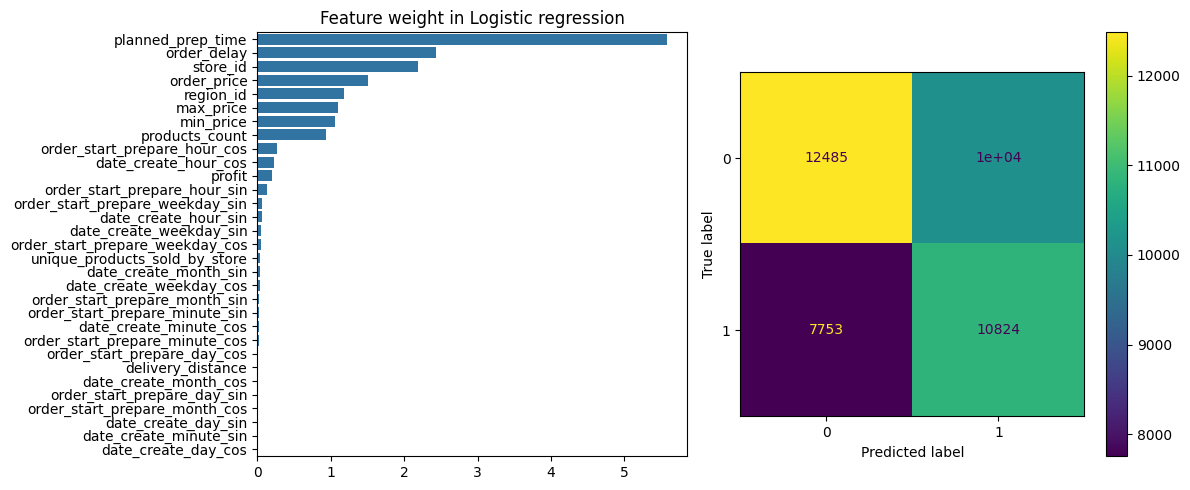

In [40]:
logistic_regressor_scores(clf_smote, X_test, y_test, X_smote, y_smote, cv=5, cv_scoring=cv_scoring, best_threshold=best_threshold_smote, plot=True)

after balancing, the model performs better on the f1_score cross validation

In [41]:
X_borderline_smote, y_borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=500)\
    .fit_resample(X_train, y_train)

print(X_train.shape, y_train.value_counts())
print(X_borderline_smote.shape, y_borderline_smote.value_counts())

(357792, 31) on_time
0    191241
1    166551
Name: count, dtype: int64
(382482, 31) on_time
0    191241
1    191241
Name: count, dtype: int64


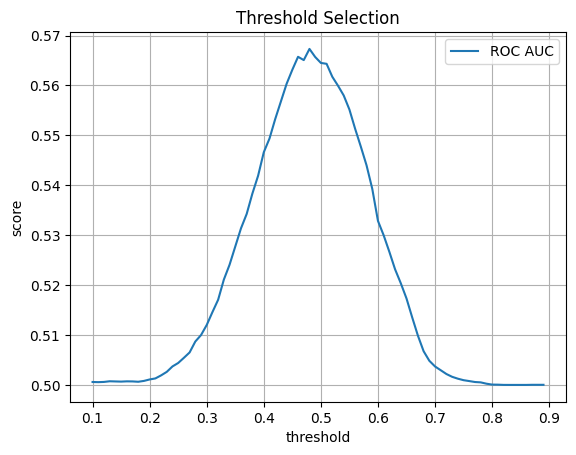

In [42]:
clf_bln_smote, min_of_all_scores__best_threshold = logistic_regressor(X_borderline_smote, y_borderline_smote, X_test, y_test, 
                                                                      objective_targets=target_metrics, objectives_names=objective_names, 
                                                                      plot=True)
min_of_all_scores, best_threshold_borderline_smote = min_of_all_scores__best_threshold

----Logistic Regression Coefficients----
- Testing accuracy = 0.565 
- Testing precision = 0.516 
- Testing recall = 0.587 
- Testing f1_score = 0.549 
- Testing ROC AUC = 0.567


- Cross validate:  {'fit_time': array([2.8 , 3.76, 4.81, 3.99, 3.86]), 'score_time': array([0.06, 0.05, 0.06, 0.05, 0.05]), 'test_roc_auc': array([0.6 , 0.61, 0.61, 0.61, 0.6 ])}


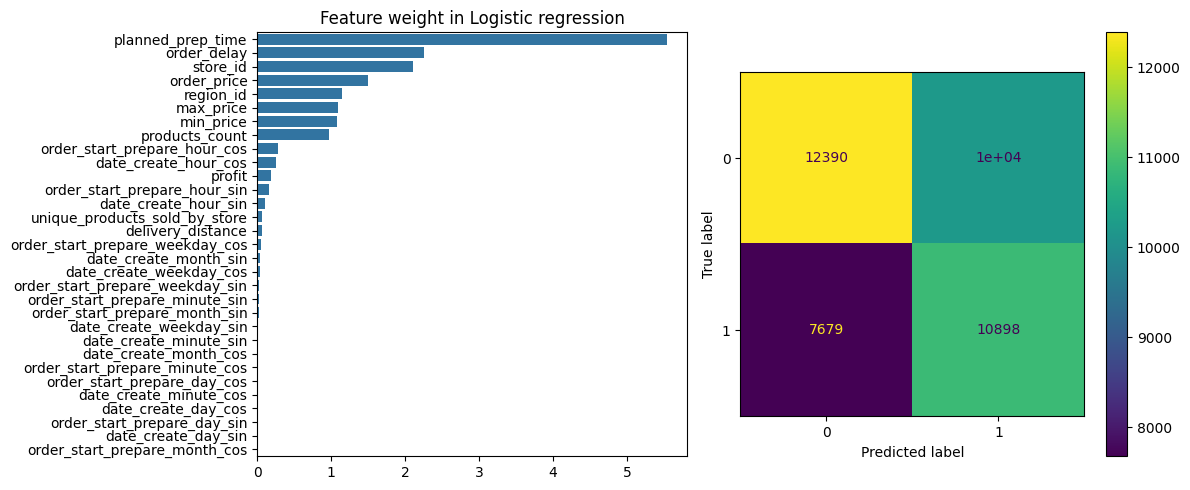

In [43]:
logistic_regressor_scores(clf_bln_smote, X_test, y_test, X_borderline_smote, y_borderline_smote, cv=5, cv_scoring=cv_scoring, 
                          best_threshold=best_threshold_borderline_smote, plot=True)

almost the same thing, although the f1_score has increased slightly in the test

### SVC

In [44]:
X_sample = X_borderline_smote.sample(10000)
y_sample = y_borderline_smote.loc[X_sample.index]

svc = SVC(kernel='rbf', verbose=1).fit(X_sample, y_sample)

[LibSVM]

......*
optimization finished, #iter = 6916
obj = -8790.466180, rho = -3.534747
nSV = 9279, nBSV = 9036
Total nSV = 9279


- Testing accuracy = 0.558 
- Testing precision = 0.510 
- Testing recall = 0.468 
- Testing f1_score = 0.488 
- Testing ROC AUC = 0.550

               precision    recall  f1-score   support

           0       0.63      0.59      0.61     24155
           1       0.47      0.51      0.49     17031

    accuracy                           0.56     41186
   macro avg       0.55      0.55      0.55     41186
weighted avg       0.56      0.56      0.56     41186



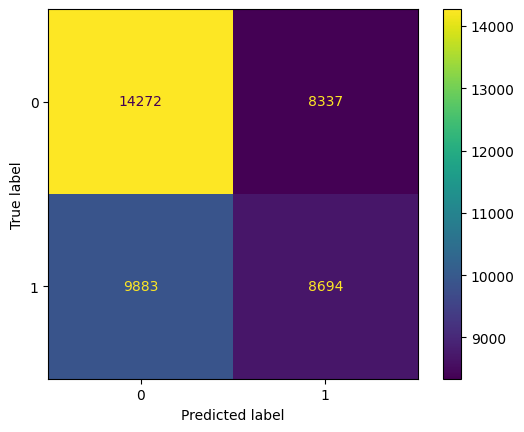

In [45]:
scores(svc, X_test, y_test, X_sample, y_sample, cv=None, threshold=None)
y_pred = svc.predict(X_test)
print("\n", metrics.classification_report(y_pred, y_test))

### Neural Network (MLP)

In [46]:
X_borderline_smote.shape

(382482, 31)

In [47]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
X_train_tr, X_test_tr, y_train_tr, y_test_tr = (torch.tensor(batch.values, dtype=torch.float32, device=device) 
                                                                for batch 
                                                                in (X_borderline_smote, X_test, y_borderline_smote, y_test))

type(X_train_tr), X_train_tr.shape, type(y_train_tr), y_train_tr.shape

(torch.Tensor, torch.Size([382482, 31]), torch.Tensor, torch.Size([382482]))

In [48]:
# Архитектура модели
class SimpleNN(nn.Module):
    def __init__(self, fc1=108, dropout1=0.1007, fc2=213, dropout2=0.018, **params):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(nn.LazyLinear(fc1), nn.ELU(), nn.Dropout(dropout1),
                                 nn.Linear(fc1, fc2), nn.BatchNorm1d(fc2), nn.ELU(), nn.Dropout(dropout2),
                                 nn.Linear(fc2, 1), nn.Sigmoid() # For binary classification
                                 )

    def forward(self, x):
        return self.net(x)
    

    def apply_init(self ,inputs):
        inputs = inputs.to(next(self.net.parameters()).device)
        self.forward(inputs)
        for module in self.net:
            if type(module) == nn.Linear:
                nn.init.xavier_uniform_(module.weight)

In [230]:
model = SimpleNN()
# model = SimpleNN(**fine_tuned_hparams)

model.apply_init(X_train_tr)

In [234]:
# Функция потерь для бинарной классификации
criterion = nn.BCEWithLogitsLoss()
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1.25e-12)

In [108]:
# Обучение модели
def train(model, device, criterion, optimizer, data, target, epochs=10000):
    # Move data, targets and weights to the specified device (CPU/GPU)
    model = model.to(device)
    data, target = data.to(device), target.to(device)
    model.train()  # Set model to training mode
    
    total_loss = 0  # To track total loss for the epoch
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data).squeeze()  # Выход сжимаем для BCEWithLogitsLoss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        # Accumulate loss for the entire epoch
        total_loss += loss.item()
        if epoch % 10 == 0:  # Печатаем каждые 100 эпох
            # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
            # Print average loss for the epoch
            print(f'====> Epoch: {epoch} Average Training loss: {total_loss / 100:.6f}')
            total_loss = 0
            

In [117]:
def get_best_threshold_from_predproba(pred_proba, y_test, objective_targets, objectives_names, plot=False):
    thresholds = np.arange(0.001, 0.99, 0.001)

    averaged_results = []
    results = [[] for i in range(len(objective_targets)) ]
    for i in thresholds:
        # y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
        y_test_pred_thr = (pred_proba > i).float() 
        [
            results[idx].append(metric_func(y_test, y_test_pred_thr)) 
            for idx, metric_func 
            in enumerate(objective_targets)
        ]
        averaged_results.append(np.min([result[-1] for result in results]))
    
    if plot:
        [plt.plot(thresholds, results[idx], label=objectives_names[idx]) 
        for idx, metric in enumerate(objective_targets)]
        plt.title('Threshold Selection')
        plt.xlabel('threshold')
        plt.ylabel('score')
        plt.legend()
        plt.grid()

    return np.max(averaged_results), thresholds[np.argmax(averaged_results)]

In [70]:
# Функция для оценки точности
def test(model, data, target, criterion,  
         objective_targets=target_metrics, objectives_names=objective_names, 
         verbose=1, plot=True):
    model.eval()
    model.to('cpu')
    data, target = data.to('cpu'), target.to('cpu')
    with torch.no_grad():
        outputs = model(data).squeeze()

        loss = criterion(outputs, target).item()
        score, best_threshold = get_best_threshold_from_predproba(outputs, target, 
                                                                objective_targets=objective_targets, 
                                                                objectives_names=objectives_names, 
                                                                plot=plot)
        predicted = (outputs > best_threshold).float() 

        if verbose:
            accuracy = metrics.accuracy_score(target, predicted)
            precision = metrics.precision_score(target, predicted)
            recall = metrics.recall_score(target, predicted)
            f1_score = metrics.f1_score(target, predicted)
            roc_auc = metrics.roc_auc_score(target, predicted)
            print('Loss: ', loss,
                '\nAccuracy: ', accuracy,
                '\nPrecision: ', precision,
                '\nRecall: ', recall,
                '\nF1-score', f1_score,
                '\nROC AUC: ', roc_auc)
        if plot:
            cm = confusion_matrix(target, predicted)
            _, ax = plt.subplots(1,2, figsize=(15,5))
            ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax[0])
            metrics.RocCurveDisplay.from_predictions(target, outputs.detach().numpy(), ax=ax[1])
    return score, best_threshold
      

In [235]:
train(model, device, criterion, optimizer, X_train_tr, y_train_tr, epochs=10000)

====> Epoch: 0 Average Training loss: 0.007256
====> Epoch: 100 Average Training loss: 0.725587
====> Epoch: 200 Average Training loss: 0.725591
====> Epoch: 300 Average Training loss: 0.725587
====> Epoch: 400 Average Training loss: 0.725590
====> Epoch: 500 Average Training loss: 0.725585
====> Epoch: 600 Average Training loss: 0.725590
====> Epoch: 700 Average Training loss: 0.725586
====> Epoch: 800 Average Training loss: 0.725589
====> Epoch: 900 Average Training loss: 0.725588
====> Epoch: 1000 Average Training loss: 0.725589
====> Epoch: 1100 Average Training loss: 0.725590
====> Epoch: 1200 Average Training loss: 0.725585
====> Epoch: 1300 Average Training loss: 0.725591
====> Epoch: 1400 Average Training loss: 0.725584
====> Epoch: 1500 Average Training loss: 0.725590
====> Epoch: 1600 Average Training loss: 0.725587
====> Epoch: 1700 Average Training loss: 0.725587
====> Epoch: 1800 Average Training loss: 0.725586
====> Epoch: 1900 Average Training loss: 0.725586
====> Epoch:

KeyboardInterrupt: 

Loss:  0.6943737864494324 
Accuracy:  0.5734926300964037 
Precision:  0.5273279352226721 
Recall:  0.5324905863367402 
F1-score 0.5298966864728869 
ROC AUC:  0.5698617776090765


0.5273279352226721

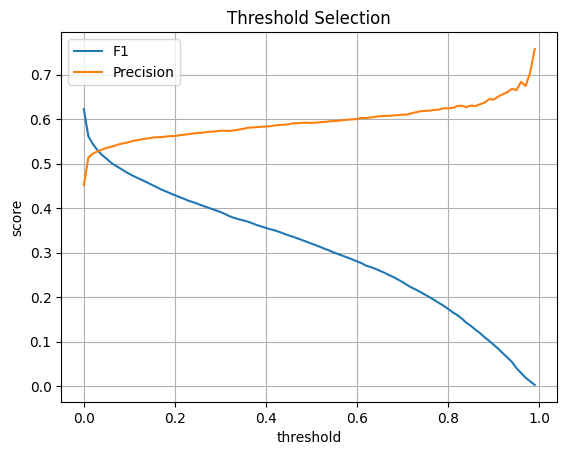

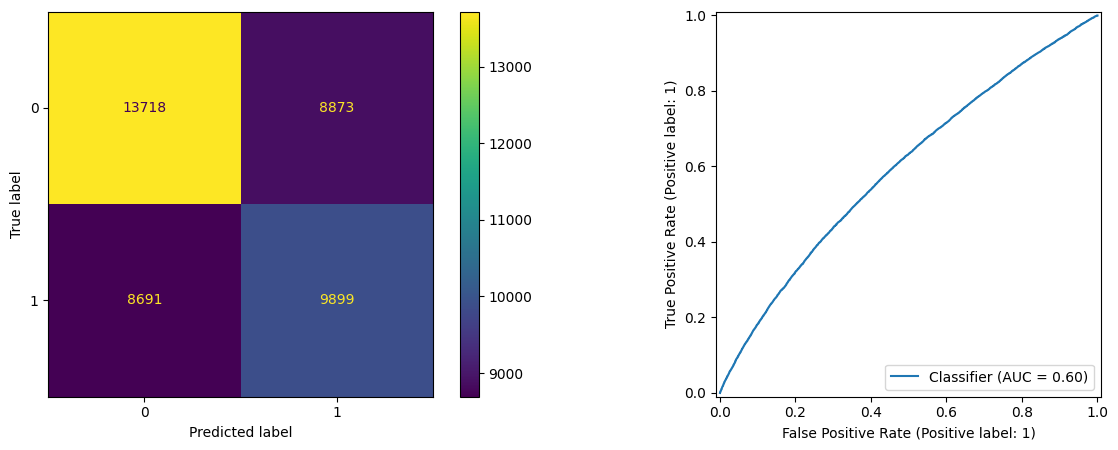

In [144]:
test(model, X_test_tr, y_test_tr, criterion)

### Tuning hyperparameters

In [52]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)

In [53]:
def preprocess(**params):
    global orders
    df = orders.copy()
    if params['sort_dates_on']:
        df = sort_dates(df, date_columns)

    selected_features = ['store_id', 'profit', 'delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready','status_id',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
    df = df[selected_features]
    
    features_for_rm_outls = ['profit', 'delivery_distance', 'planned_prep_time', 'products_count',
                             'order_price', 'max_price', 'min_price', 'unique_products_sold_by_store']
    
    quantiles = np.array([[params['lower_outliers_bound'], params['upper_outliers_bound']]]*len(features_for_rm_outls))
    df = rm_outliers(df, features_for_rm_outls, quantiles, 0)

    
    X_train, X_test = train_test_split(df, train_size=0.9, shuffle=False)

    X_train = impute_dates(X_train, params['imputing_method_for_dates'])
    X_test = impute_dates(X_test, params['imputing_method_for_dates'])

    X_train, y_train = extract_target(X_train, params['q_target'], verbose=0)
    X_test, y_test = extract_target(X_test, test_subset=True, verbose=0)

    data_features = ['date_create','order_start_prepare']
    X_train = extract_date_feat(X_train, data_features)
    X_test = extract_date_feat(X_test, data_features)


    X_train, X_test, y_train, y_test = simple_imputer(X_train, X_test, y_train, y_test, params['restore_numerical_nans'], 
                                                      params.get('imputing_method_for_numerical', None), 
                                                      params.get('imputing_method_for_simple_imputer', None), 
                                                      verbose=0)
    
    cat_features = ['store_id','region_id', 'status_id']
    if params['encoder_class'] == 'CatboostEncoder':
        encoder = cat_boost.CatBoostEncoder(cols=cat_features, random_state=42)
    elif params['encoder_class'] == 'BinaryEncoder':
        encoder = BinaryEncoder(cols=cat_features)
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test, y_test)

    match params['scaler_class']:
        case 'StandardScaler':
            scaler = preprocessing.StandardScaler()
        case 'MinMaxScaler':
            scaler = preprocessing.MinMaxScaler()
        case 'RobustScaler':
            scaler = preprocessing.RobustScaler()
            
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out(), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out(), index=X_test.index)

    X_borderline_smote, y_borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=500)\
                                                .fit_resample(X_train, y_train)

    
    return X_borderline_smote, X_test, y_borderline_smote, y_test
    

In [54]:
def catboost_classifier(trial: optuna.Trial, X_train, y_train, X_test, y_test, 
                        objective_targets=target_metrics,
                        objectives_names=objective_names, 
                        plot=False):
    param = trial.params
    param['catboost_classifier'] = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "used_ram_limit": "3gb",
    }

    if param['catboost_classifier']["bootstrap_type"] == "Bayesian":
        param['catboost_classifier']["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param['catboost_classifier']["bootstrap_type"] == "Bernoulli":
        param['catboost_classifier']["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    gbm = CatBoostClassifier(**param['catboost_classifier']).fit(X_train, y_train, 
                                        eval_set=[(X_test, y_test)], 
                                        verbose=0, early_stopping_rounds=100)
    return get_best_threshold(gbm, X_test, y_test, objective_targets, objectives_names, plot)

In [103]:
def neural_classifier(trial: optuna.Trial, X_train, y_train, X_test, y_test, 
                        objective_targets=target_metrics,
                        objectives_names=objective_names, 
                        plot=False):
    neuralnet_params = {
        "fc1": trial.suggest_int("fc1", 32, 128),
        "dropout1": trial.suggest_float("dropout1", 1e-4, 0.99, log=True),
        "fc2": trial.suggest_int("fc2", 64, 256),
        "dropout2": trial.suggest_float("dropout2", 1e-4, 0.99, log=True),
        "optim": trial.suggest_categorical("optim", ["Adam", "AdamW", "SGD"]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-12, 1.0, log=True),
        "lr": trial.suggest_float("lr", 1e-12, 1.0, log=True)
    }

    net = SimpleNN(**neuralnet_params)
    

    # Оптимизатор
    match neuralnet_params['optim']:
        case 'SGD':
            optimizer = optim.SGD(net.parameters(), lr=0.001, 
                                  momentum=trial.suggest_float("momentum", 1e-12, 1.0, log=True),
                                  weight_decay=neuralnet_params['weight_decay'])
        case 'Adam' | 'AdamW':
            Adams_params = dict(lr=0.001, 
                                eps=trial.suggest_float("eps", 1e-12, 1e-1, log=True),
                                weight_decay=neuralnet_params['weight_decay'])
            
            if neuralnet_params['optim']=='Adam':
                optimizer = optim.Adam(net.parameters(), **Adams_params)
            else:
                optimizer = optim.AdamW(net.parameters(), **Adams_params)

    criterion = nn.BCEWithLogitsLoss()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    X_train_tr, X_test_tr, y_train_tr, y_test_tr = (torch.tensor(batch.values, dtype=torch.float32, device=device) 
                                                                for batch 
                                                                in (X_train, X_test, y_train, y_test))
    net.apply_init(X_train_tr)
    train(net, device, criterion, optimizer, X_train_tr, y_train_tr, epochs=50)
    
    return test(net, X_test_tr, y_test_tr, criterion, objective_targets, objectives_names, verbose=plot, plot=plot)

In [104]:
def configure_preprocess_params(trial: optuna.Trial):
    param = {
        "lower_outliers_bound": trial.suggest_float("lower_outliers_bound", 1e-5, 0.4, log=True),
        "upper_outliers_bound": trial.suggest_float("upper_outliers_bound", 0.6, 1.0, log=True),
        "sort_dates_on": trial.suggest_int("sort_dates_on", 0, 1),
        "q_target": trial.suggest_float("q_target", 0.5, 1.0, log=True),
        "imputing_method_for_dates": trial.suggest_categorical("imputing_method_for_dates", ["mode", "mean", "median"]),
        "restore_numerical_nans": trial.suggest_int("restore_numerical_nans", 0, 1),
        "encoder_class": trial.suggest_categorical("encoder_class", ["CatboostEncoder", "BinaryEncoder"]),
        "scaler_class": trial.suggest_categorical("scaler_class", ['MinMaxScaler', 'StandardScaler', 'RobustScaler']),
        "model": trial.suggest_categorical("model", ['NeuralNetwork'])
    }
                                                    # 'LogisticRegressor', 
                                                    # 'CatBoostClassifier'
                                                    

    if param["restore_numerical_nans"]:
        param["imputing_method_for_numerical"] = trial.suggest_categorical("imputing_method_for_numerical", ["mode", "mean", "median"])
        param["imputing_method_for_simple_imputer"] = trial.suggest_categorical("imputing_method_for_simple_imputer", ["most_frequent", "mean", "median"])
    return param

In [105]:
params = dict(lower_outliers_bound=0.25,
                upper_outliers_bound=0.75, 
                sort_dates_on=True, 
                q_target=0.9,
                imputing_method_for_dates='mean',
                restore_numerical_nans=False,
                encoder_class='CatboostEncoder',
                scaler_class='MinMaxScaler',
                model='NeuralNetwork')

params = {'lower_outliers_bound': 0.18234454586934673, 'upper_outliers_bound': 0.7343575199390663, 'sort_dates_on': 1, 'q_target': 0.9944393128480882, 'imputing_method_for_dates': 'mode', 'restore_numerical_nans': 1, 'encoder_class': 'BinaryEncoder', 'scaler_class': 'StandardScaler', 'model': 'NeuralNetwork', 'imputing_method_for_numerical': 'median', 'imputing_method_for_simple_imputer': 'most_frequent'}
X_train, X_test, y_train, y_test = preprocess(**params)

In [106]:
def objective(trial: optuna.Trial):
    global X_train, X_test, y_train, y_test, params
    # params = configure_preprocess_params(trial)
    # X_train, X_test, y_train, y_test = preprocess(**params)
    
    match params['model']:
        case 'LogisticRegressor':
            score, best_threshold = logistic_regressor(X_train, y_train, X_test, y_test, target_metrics, objective_names)
            trial.set_user_attr('best_threshold', best_threshold)
            return score
        case 'CatBoostClassifier':
            score, best_threshold = catboost_classifier(trial, X_train, y_train, X_test, y_test, target_metrics, objective_names)
            trial.set_user_attr('best_threshold', best_threshold)
            return score
        case 'NeuralNetwork':
            score, best_threshold = neural_classifier(trial, X_train, y_train, X_test, y_test, target_metrics, objective_names)
            trial.set_user_attr('best_threshold', best_threshold)
            return score
        # case 'SVC':
    

In [109]:
study = optuna.create_study(storage="sqlite:///../db.sqlite3",
                            study_name="assignment-fine-tuning_neuralnet_50",
                            direction="maximize", 
                            load_if_exists=True)
study.optimize(objective, n_trials=1000, 
            #    timeout=600, 
               show_progress_bar=True)

[I 2024-10-06 18:00:21,249] Using an existing study with name 'assignment-fine-tuning_neuralnet_50' instead of creating a new one.


  0%|          | 0/1000 [00:00<?, ?it/s]

====> Epoch: 0 Average Training loss: 0.007416
====> Epoch: 10 Average Training loss: 0.074095
====> Epoch: 20 Average Training loss: 0.073962
====> Epoch: 30 Average Training loss: 0.073828
====> Epoch: 40 Average Training loss: 0.073690
[I 2024-10-06 18:00:28,085] Trial 10 finished with value: 0.5013274931237393 and parameters: {'fc1': 123, 'dropout1': 0.03612698429756901, 'fc2': 211, 'dropout2': 0.0002574895063514129, 'optim': 'AdamW', 'weight_decay': 6.722411115654837e-11, 'lr': 1.0722584863839228e-12, 'eps': 0.05006234588206154}. Best is trial 1 with value: 0.5665663992873945.
====> Epoch: 0 Average Training loss: 0.007331
====> Epoch: 10 Average Training loss: 0.071746
====> Epoch: 20 Average Training loss: 0.070445
====> Epoch: 30 Average Training loss: 0.069664
====> Epoch: 40 Average Training loss: 0.069185
[I 2024-10-06 18:00:34,392] Trial 11 finished with value: 0.5664805480938357 and parameters: {'fc1': 94, 'dropout1': 0.000289353966848687, 'fc2': 151, 'dropout2': 0.0074361

KeyboardInterrupt: 

In [52]:
print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')

trial = study.best_trial

print("Trial id: ", trial._trial_id,
        "\nUser attributes: ", trial._user_attrs)
print('\tMetrics')

print("Min metric: ", trial.value)
print('\tParameters')
for param, value in trial.params.items():
    print(param, ": ", value)
print("\n\n")

Number of finished trials: 649

Trial id:  787 
User attributes:  {'best_threshold': 0.1}
	Metrics
Min metric:  0.5423207744636316
	Parameters
fc1 :  78
dropout1 :  0.17458270263200448
fc2 :  243
dropout2 :  0.00015176425353145224
optim :  AdamW
weight_decay :  7.278741082229771e-09
lr :  1.0479187218990042e-05
eps :  2.77361800615728e-07





In [110]:
fine_tuned_hparams = {'fc1': 121, 
                      'dropout1': 0.001458158040982149, 
                      'fc2': 98, 
                      'dropout2': 0.00657105461335662, 
                      'weight_decay': 0.000490763304547915, 
                      'lr': 8.045869423050157e-08, 
                      'eps': 3.1014444037828963e-07}

In [111]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
X_train_tr, X_test_tr, y_train_tr, y_test_tr = (torch.tensor(batch.values, dtype=torch.float32, device=device) 
                                                                for batch 
                                                                in (X_train, X_test, y_train, y_test))

type(X_train_tr), X_train_tr.shape, type(y_train_tr), y_train_tr.shape

(torch.Tensor, torch.Size([323580, 46]), torch.Tensor, torch.Size([323580]))

In [112]:
model = SimpleNN(**fine_tuned_hparams)

model.apply_init(X_train_tr)

In [113]:
# Функция потерь для бинарной классификации
criterion = nn.BCEWithLogitsLoss()
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=fine_tuned_hparams['lr'], weight_decay=fine_tuned_hparams['weight_decay'], eps=fine_tuned_hparams['eps'])

In [128]:
train(model, device, criterion, optimizer, X_train_tr, y_train_tr, epochs=500)

====> Epoch: 0 Average Training loss: 0.007359
====> Epoch: 10 Average Training loss: 0.073594
====> Epoch: 20 Average Training loss: 0.073595
====> Epoch: 30 Average Training loss: 0.073594
====> Epoch: 40 Average Training loss: 0.073595
====> Epoch: 50 Average Training loss: 0.073595
====> Epoch: 60 Average Training loss: 0.073594
====> Epoch: 70 Average Training loss: 0.073594
====> Epoch: 80 Average Training loss: 0.073593
====> Epoch: 90 Average Training loss: 0.073592
====> Epoch: 100 Average Training loss: 0.073593
====> Epoch: 110 Average Training loss: 0.073592
====> Epoch: 120 Average Training loss: 0.073593
====> Epoch: 130 Average Training loss: 0.073593
====> Epoch: 140 Average Training loss: 0.073592
====> Epoch: 150 Average Training loss: 0.073592
====> Epoch: 160 Average Training loss: 0.073592
====> Epoch: 170 Average Training loss: 0.073593
====> Epoch: 180 Average Training loss: 0.073591
====> Epoch: 190 Average Training loss: 0.073590
====> Epoch: 200 Average Traini

Loss:  0.7661840319633484 
Accuracy:  0.5386260277685752 
Precision:  0.4826038159371493 
Recall:  0.08472349927755156 
F1-score 0.14414213084529862 
ROC AUC:  0.5038959322053888


(0.5038959322053888, 0.908)

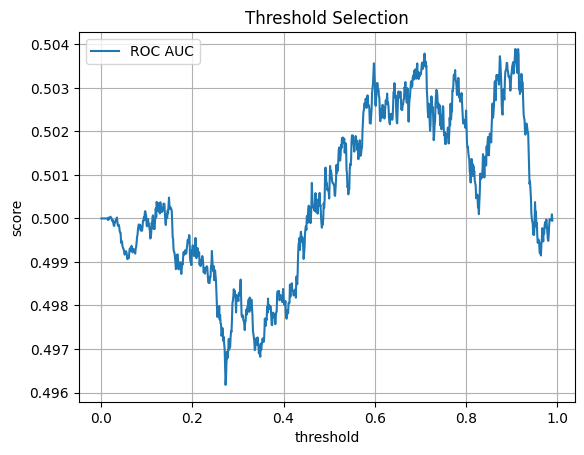

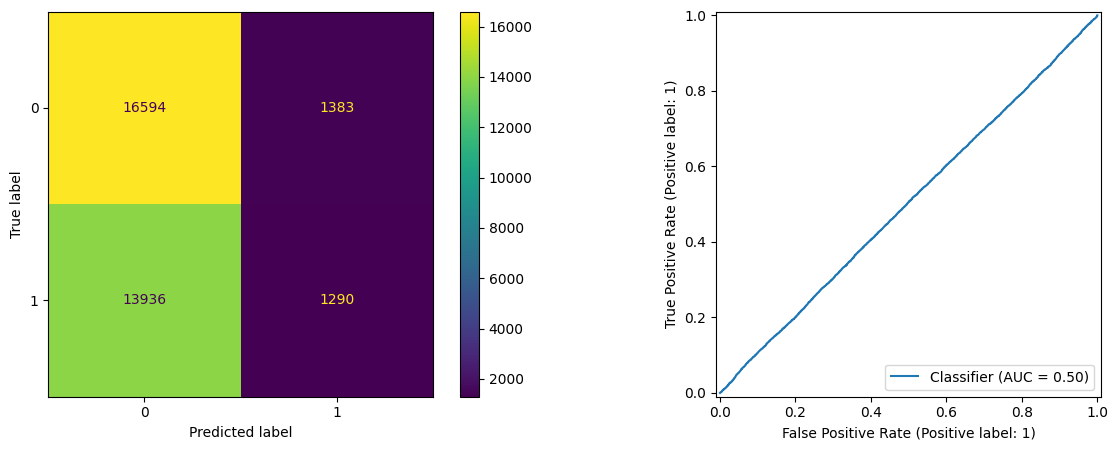

In [129]:
test(model, X_test_tr, y_test_tr, criterion)